In [1]:
# setup django project in jupiter
from django_for_jupyter import init_django
init_django("dpm_env")

In [2]:
# libraries
import requests as req
from django.urls import reverse
import json
from accounts import views as account_view
from projects import views as project_view
from project_charter import views as project_charter_view
from project_budget import views as project_budget_view
from project_resources import views as project_resources_view
from project_procurements import views as project_procurements_view
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from datetime import datetime

In [3]:
# user login details
user_pmo = {"email": "pmo@email.com", "password": "pmo12345"}
user_pm  = {"email": "pm@email.com", "password": "pm123456"}
user_ps  = {"email": "ps@email.com", "password": "ps123456"}
user_pc  = {"email": "pc@email.com", "password": "pc123456"}

In [4]:
# some methods for http requests
base_url = "http://localhost:8000"

def post_request(data, route, auth_token=None, path_param=None, type_json=False):
    headers = {}
    if path_param:
        path = reverse(route, None, path_param)
    else:
        path = reverse(route)
    if type_json:
        headers = dict(headers, **{'Content-Type': 'application/json'})
    if auth_token:
        headers = dict(headers, **{'Authorization': f'token {auth_token}'})
    data = json.dumps(data)
    url = base_url + path
    
    return req.post(url, headers=headers, data=data)


def patch_request(data, route, auth_token=None, path_param=None, type_json=False):
    headers = {}
    if path_param:
        path = reverse(route, None, path_param)
    else:
        path = reverse(route)
    if type_json:
        headers = dict(headers, **{'Content-Type': 'application/json'})
    if auth_token:
        headers = dict(headers, **{'Authorization': f'token {auth_token}'})
    data = json.dumps(data)
    url = base_url + path
    
    return req.patch(url, data=data, headers=headers)


def get_request(route, auth_token=None, path_param=None):
    headers = {}
    if path_param:
        path = reverse(route, None, path_param)
    else:
        path = reverse(route)
    if auth_token:
        headers = {'Authorization': f'token {auth_token}'}
    url = base_url + path
    
    return req.get(url, headers=headers)

def delete_request(route, auth_token=None, path_param=None):
    headers = {}
    path = reverse(route, None, path_param)
    headers = {'Authorization': f'token {auth_token}'}
    url = base_url + path
    
    return req.delete(url, headers=headers)

In [5]:
# login api
route = account_view.LoginAPI.name
# login as 'project management office'
response = post_request(data=user_pmo, route=route, type_json=True).json()
stakeholder_pmo = response.get('user')
token_pmo = response.get('auth_token')

# login as 'project manager'
response = post_request(data=user_pm, route=route, type_json=True).json()
stakeholder_pm = response.get('user')
token_pm = response.get('auth_token')

# login as 'project sponsor'
response = post_request(data=user_ps, route=route, type_json=True).json()
stakeholder_ps = response.get('user')
token_ps = response.get('auth_token')

# login as 'project controller'
response = post_request(data=user_pc, route=route, type_json=True).json()
stakeholder_pc = response.get('user')
token_pc = response.get('auth_token')

df = pd.json_normalize([stakeholder_pmo, stakeholder_pm, stakeholder_ps, stakeholder_pc])
df

,id,first_name,last_name,email,user_role,is_active
0,36,Luca,Verdi,pmo@email.com,PMO,True
1,37,Lucas,Andos,pm@email.com,PM,True
2,38,Giovanni,Valdieri,ps@email.com,PS,True
3,39,Maria,Lilla,pc@email.com,PC,True


In [6]:
# As 'project management office'
# create a new project
author = stakeholder_pmo.get('id')
project = {
    "project_name": "Tesi Ranno",
    "author": author
}

route = project_view.ProjectAPI.name
response = post_request(data=project, route=route, auth_token=token_pmo, type_json=True).json()
result = response.get('detail')
result_project = response.get('project')
result_project["created"] = datetime.strptime(result_project.get("created"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)
author = result_project.get("author")
stakeholders = result_project.get("stakeholders")
result_project.pop('project_charter')
result_project.pop('author')
result_project.pop('stakeholders')

print("Result: ", result)
print("Project:")
display(pd.json_normalize(result_project))
print("Author of the project:")
display(pd.json_normalize(author))
print("Stakeholders of the project:")
display(pd.json_normalize(stakeholders))

Result:  Project created successfully.
Project:


,id,project_name,created
0,52,Tesi Ranno,2022-06-05 14:49:19


Author of the project:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO


Stakeholders of the project:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO


In [7]:
# As 'project management office'
# edit a project
project_id = result_project.get('id')
project = {
    "project_name": "Thesis project"
}

route = project_view.EditProjectAPI.name
response = patch_request(data=project, route=route, auth_token=token_pmo, path_param=[project_id], type_json=True).json()
result = response.get('detail')
print("Result: ", result)

Result:  Project name updated successfully


In [8]:
# As 'project management office'
# get updated project instance
route = project_view.ProjectDetailsAPI.name
response = get_request(route=route, auth_token=token_pmo, path_param=[project_id]).json()

response["created"] = datetime.strptime(response.get("created"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)
author = response.get("author")
stakeholders = response.get("stakeholders")
response.pop('project_charter')
response.pop('author')
response.pop('stakeholders')

print("Project:")
display(pd.json_normalize(response))
print("Author of the project:")
display(pd.json_normalize(author))
print("Stakeholders of the project:")
display(pd.json_normalize(stakeholders))

Project:


,id,project_name,created
0,52,Thesis project,2022-06-05 14:49:19


Author of the project:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO


Stakeholders of the project:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO


In [9]:
# method to get all stakeholders of a project
def get_all_stakeholders_of_project(project):
    route = project_view.GetStakeholdersOfProjectAPI.name
    response = get_request(route=route, auth_token=token_pmo, path_param=[project]).json()

    df = pd.DataFrame (response['stakeholders'], columns = ['id', 'first_name', 'last_name', 'email', 'user_role'])
    return df

In [10]:
# As 'an author of the project' and 'project management office'
# add a new stakeholder to the project
project = result_project.get('id')
pm = stakeholder_pm.get('id')
ps = stakeholder_ps.get('id')
pc = stakeholder_pc.get('id')
stakeholders = { 
    "stakeholders": [pm, ps, pc]
}
route = project_view.AddStakeholdersToProjectAPI.name
response = patch_request(data=stakeholders, route=route, auth_token=token_pmo, path_param=[project], type_json=True).json()
result = response.get('detail')
print("Result: ", result)

Result:  Stakeholders added successfully


In [11]:
# demonstrate stakeholder list after adding new one
print("Stakeholders after adding new one:")
get_all_stakeholders_of_project(project)

Stakeholders after adding new one:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO
1,37,Lucas,Andos,pm@email.com,PM
2,38,Giovanni,Valdieri,ps@email.com,PS
3,39,Maria,Lilla,pc@email.com,PC


In [12]:
# remove a stakeholder from a project
stakeholders = { 
    "stakeholders": [ps]
}
route = project_view.RemoveStakeholdersFromProjectAPI.name
response = patch_request(data=stakeholders, route=route, auth_token=token_pmo, path_param=[project], type_json=True).json()
result = response.get('detail')
print("Result: ", result)

Result:  Stakeholders removed successfully


In [13]:
# demonstrate stakeholder list after removing one
print("Stakeholders after removing one:")
get_all_stakeholders_of_project(project)

Stakeholders after removing one:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO
1,37,Lucas,Andos,pm@email.com,PM
2,39,Maria,Lilla,pc@email.com,PC


In [14]:
# As 'an authorized stakeholder' 
# get my projects where I am a stakeholder
route = project_view.GetProjectsOfStakeholderAPI.name
response = get_request(route=route, auth_token=token_pm).json()
for res in response:
    res["created"] = datetime.strptime(res.get("created"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)

print("Projects:")
df = pd.json_normalize(response)
df

Projects:


,id,project_name,created,author.id,author.first_name,author.last_name,author.email,author.user_role
0,52,Thesis project,2022-06-05 14:49:19,36,Luca,Verdi,pmo@email.com,PMO


In [15]:
# get permissions of a stakeholder for given project
def get_all_permissions_of_stakeholder_over_project(stakeholder, project):
    route = project_view.GetProjectPermissionsOfUserAPI.name
    response = get_request(route=route, auth_token=token_pm, path_param=[stakeholder, project]).json()

    if len(response['permissions']) > 0:
        df = pd.DataFrame (response['permissions'], columns = ['permissions'])
        return df
    else:
        print("There is not any assigned permission")

In [16]:
# As 'an author of the project'
# assign all project permissions to PM
content = {
    "user_id": pm,
    "project_id": project
}
route = project_view.AssignAllProjectPermissionsToStakeholderAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 201:
    print("Result: Permissions assigned")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Permission assignment failed")
    print("HTTP status code: ", response.status_code)

Result: Permissions assigned
HTTP status code:  201


In [17]:
# demonstrate a list of permissions of stakeholder over a project
print("Permissions:")
get_all_permissions_of_stakeholder_over_project(pm, project)

Permissions:


,permissions
0,add_project
1,add_project_charter
2,add_project_contract
3,add_project_resource
4,add_project_spendings
5,change_project
6,change_project_charter
7,change_project_contract
8,change_project_resource
9,change_project_spendings


In [18]:
# As 'an author of the project'
# delete main project permissions of a stakeholder
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["change_project", "add_project", "delete_project", "view_project"]
}
route = project_view.DeleteProjectPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 204:
    print("Result: Main project permissions deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete permissions request failed")
    print("HTTP status code: ", response.status_code)

Result: Main project permissions deleted successfully
HTTP status code:  204


In [19]:
# demonstrate a list of permissions of stakeholder over a project after deleting project permissions
print("Permissions after deleting main project permissions:")
get_all_permissions_of_stakeholder_over_project(pm, project)

Permissions after deleting main project permissions:


,permissions
0,add_project_charter
1,add_project_contract
2,add_project_resource
3,add_project_spendings
4,change_project_charter
5,change_project_contract
6,change_project_resource
7,change_project_spendings
8,delete_project_charter
9,delete_project_contract


In [20]:
# As 'an author of the project'
# delete project charter permissions of a stakeholder
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["delete_project_charter", "change_project_charter", "add_project_charter", "view_project_charter"]
}
route = project_charter_view.DeleteProjectCharterPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 204:
    print("Result: Project charter permissions deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete permissions request failed")
    print("HTTP status code: ", response.status_code)

Result: Project charter permissions deleted successfully
HTTP status code:  204


In [21]:
# demonstrate a list of permissions of stakeholder over a project after deleting project charter permissions
print("Permissions after deleting project charter permissions:")
get_all_permissions_of_stakeholder_over_project(pm, project)

Permissions after deleting project charter permissions:


,permissions
0,add_project_contract
1,add_project_resource
2,add_project_spendings
3,change_project_contract
4,change_project_resource
5,change_project_spendings
6,delete_project_contract
7,delete_project_resource
8,delete_project_spendings
9,view_project_contract


In [22]:
# As 'an author of the project'
# delete project resources permissions of a stakeholder
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["add_project_resource", "delete_project_resource", "change_project_resource", "view_project_resource"]
}
route = project_resources_view.DeleteProjectResourcePermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 204:
    print("Result: Project resources permissions deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete permissions request failed")
    print("HTTP status code: ", response.status_code)

Result: Project resources permissions deleted successfully
HTTP status code:  204


In [23]:
# demonstrate a list of permissions of stakeholder over a project after deleting project resources permissions
print("Permissions after deleting project resources permissions:")
get_all_permissions_of_stakeholder_over_project(pm, project)

Permissions after deleting project resources permissions:


,permissions
0,add_project_contract
1,add_project_spendings
2,change_project_contract
3,change_project_spendings
4,delete_project_contract
5,delete_project_spendings
6,view_project_contract
7,view_project_spendings


In [24]:
# As 'an author of the project'
# delete project contracts permissions of a stakeholder
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["add_project_contract", "delete_project_contract", "change_project_contract", "view_project_contract"]
}
route = project_procurements_view.DeleteProjectContractPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 204:
    print("Result: Project procurements permissions deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete permissions request failed")
    print("HTTP status code: ", response.status_code)

Result: Project procurements permissions deleted successfully
HTTP status code:  204


In [25]:
# demonstrate a list of permissions of stakeholder over a project after deleting project contract permissions
print("Permissions after deleting project contract permissions:")
get_all_permissions_of_stakeholder_over_project(pm, project)

Permissions after deleting project contract permissions:


,permissions
0,add_project_spendings
1,change_project_spendings
2,delete_project_spendings
3,view_project_spendings


In [26]:
# As 'an author of the project'
# delete project spendings permissions of a stakeholder
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["add_project_spendings", "delete_project_spendings", "change_project_spendings", "view_project_spendings"]
}
route = project_budget_view.DeleteProjectBudgetPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 204:
    print("Result: Project spendings permissions deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete permissions request failed")
    print("HTTP status code: ", response.status_code)

Result: Project spendings permissions deleted successfully
HTTP status code:  204


In [27]:
# demonstrate a list of permissions of stakeholder over a project after deleting project spendings permissions
print("Permissions after deleting project spendings permissions:")
get_all_permissions_of_stakeholder_over_project(pm, project)

Permissions after deleting project spendings permissions:
There is not any assigned permission


In [28]:
# As 'an author of the project'
# assign project charter permissions to PM
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["delete_project_charter", "change_project_charter", "add_project_charter", "view_project_charter"]    
}
route = project_charter_view.AddProjectCharterPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 201:
    print("Result: Project charter permissions assigned")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Permission assignment failed")
    print("HTTP status code: ", response.status_code)

Result: Project charter permissions assigned
HTTP status code:  201


In [29]:
# As 'project manager'
# prepare project charter
project = result_project.get('id')
author = stakeholder_pm.get('id')
project_charter = {
    "project": project,
    "author": author,
    "sow": "thesis outline",
    "contract": "Guida Studente DIGEP per la tesi",
    "business_case": "Digital PM"
}

route = project_charter_view.ProjectCharterAPI.name
response = post_request(data=project_charter, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
result_project_charter = response.get('project_charter')

print("Result: ", result)
print("Project_Charter:")
result_project_charter.pop('bus_case_swot')
result_project_charter.pop('project_budget')
result_project_charter["created"] = datetime.strptime(result_project_charter.get("created"), 
                                                      '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)
result_project_charter["last_updated"] = datetime.strptime(result_project_charter.get("last_updated"), 
                                                           '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)

df = pd.json_normalize(result_project_charter)
df

Result:  Project charter created successfully.
Project_Charter:


,id,project,author,created,last_updated,sow,contract,business_case
0,33,52,37,2022-06-05 14:50:13,2022-06-05 14:50:13,thesis outline,Guida Studente DIGEP per la tesi,Digital PM


In [30]:
# As 'project manager'
# edit a project charter
project_charter_id = result_project_charter.get('id')
# may have partial attributes
project_charter = {    
    "sow": "standard thesis outline",
    "contract": "Guida Studente DIGEP per la tesi",
    "business_case": "Research Case Digital PM"
}
route = project_charter_view.EditProjectCharterAPI.name
response = patch_request(data=project_charter, route=route, auth_token=token_pm, 
                         path_param=[project_charter_id], type_json=True).json()
result = response.get('detail')
print("Result: ", result)

Result:  Project charter updated successfully


In [31]:
# As 'project manager'
# get a project charter of a project
route = project_charter_view.ProjectCharterDetailsAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[project_charter_id]).json()
print("Project charter:")
response.pop('bus_case_swot')
response.pop('project_budget')
response["created"] = datetime.strptime(response.get("created"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)
response["last_updated"] = datetime.strptime(response.get("last_updated"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)

df = pd.json_normalize(response)
df

Project charter:


,id,project,author,created,last_updated,sow,contract,business_case
0,33,52,37,2022-06-05 14:50:13,2022-06-05 14:50:15,standard thesis outline,Guida Studente DIGEP per la tesi,Research Case Digital PM


In [32]:
# As 'project manager'
# Add BusCase SWOT
project_charter = result_project_charter.get('id')

# swot 1
swot = {
    "project_charter": project_charter,
    "swot_type": "opportunity",
    "content": "Very small legacy in PIMS"
}

route = project_charter_view.BusinessCaseSWOTAPI.name
response = post_request(data=swot, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
result_swot = response.get('swot')

data = [result_swot]

# swot2
swot = {
    "project_charter": project_charter,
    "swot_type": "opportunity",
    "content": "A standard for PM exists"
}

response = post_request(data=swot, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
result_swot = response.get('swot')
data.append(result_swot)

# swot 3
swot = {
    "project_charter": project_charter,
    "swot_type": "weakness",
    "content": "Front ends must be custom built according to corporate paractices and back end constraints"
}

response = post_request(data=swot, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
result_swot = response.get('swot')
data.append(result_swot)

# swot 4
swot = {
    "project_charter": project_charter,
    "swot_type": "strength",
    "content": "Access some services"
}

response = post_request(data=swot, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
result_swot = response.get('swot')
data.append(result_swot)

print("Result: ", result)
df = pd.json_normalize(data)
df

Result:  Business case swot added successfully.


,id,project_charter,swot_type,content
0,107,33,opportunity,Very small legacy in PIMS
1,108,33,opportunity,A standard for PM exists
2,109,33,weakness,Front ends must be custom built according to c...
3,110,33,strength,Access some services


In [33]:
# As 'project manager'
# delete a swot
swot_id = result_swot.get('id')
route = project_charter_view.DeleteBusinessCaseSWOTAPI.name
response = delete_request(route=route, auth_token=token_pm, path_param=[swot_id])
if response.status_code == 204:
    print("Result: SWOT deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: SWOT deleted successfully
HTTP status code:  204


In [34]:
# As 'project manager'
# get swot list of project charter
route = project_charter_view.SWOTListOfProjectCharterAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[project_charter]).json()

df = pd.DataFrame (response['swot-list'], columns = ['id', 'project_charter', 'swot_type', 'content'])
df

,id,project_charter,swot_type,content
0,107,33,opportunity,Very small legacy in PIMS
1,108,33,opportunity,A standard for PM exists
2,109,33,weakness,Front ends must be custom built according to c...


In [35]:
# As 'project manager'
# get a single swot instance
swot = response['swot-list'][0].get('id')
route = project_charter_view.SWOTDetailsAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[swot]).json()

df = pd.json_normalize(response)
df

,id,project_charter,swot_type,content
0,107,33,opportunity,Very small legacy in PIMS


In [36]:
# As 'an author of the project'
# assign project resources permissions to PM
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["add_project_resource", "delete_project_resource", "change_project_resource", "view_project_resource"]    
}
route = project_resources_view.AddProjectResourcePermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 201:
    print("Result: Project resources permissions assigned")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Permission assignment failed")
    print("HTTP status code: ", response.status_code)

Result: Project resources permissions assigned
HTTP status code:  201


In [37]:
# add new resources to the project
# resource 1
resource = {
    "project": project,
    "name": "engineer",
    "description": "price in eur/hour",
    "cost": 12.00,
    "category": "human"
}

route = project_resources_view.AddResourceAPI.name
response = post_request(data=resource, route=route, auth_token=token_pm, type_json=True).json()
resources = [response.get('resource')]

# resource 2
resource = {
    "project": project,
    "name": "technician",
    "description": "price in eur/hour",
    "cost": 10.00,
    "category": "human"
}

route = project_resources_view.AddResourceAPI.name
response = post_request(data=resource, route=route, auth_token=token_pm, type_json=True).json()
resources.append(response.get('resource'))

# resource 3
resource = {
    "project": project,
    "name": "purchase officer",
    "description": "price in eur/hour",
    "cost": 8.00,
    "category": "human"
}

route = project_resources_view.AddResourceAPI.name
response = post_request(data=resource, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
resources.append(response.get('resource'))

print("Result: ", result)
print("Project resources:")

df = pd.json_normalize(resources)
df

Result:  Resource added successfully.
Project resources:


,id,project,name,description,cost,unit,category
0,72,52,engineer,price in eur/hour,12.0,euro,human
1,73,52,technician,price in eur/hour,10.0,euro,human
2,74,52,purchase officer,price in eur/hour,8.0,euro,human


In [38]:
# edit a project resource
# may have partial attributes
resource_id = response.get('resource').get('id')
resource = {    
    "name": "purchase officer",
    "description": "salary in eur",
    "cost": 15.00,
    "category": "human"
}
route = project_resources_view.UpdateResourceAPI.name
response = patch_request(data=resource, route=route, auth_token=token_pm, path_param=[resource_id], type_json=True).json()
result = response.get('detail')
print("Result: ", result)

Result:  Resource updated successfully


In [39]:
# get a single resource instance
route = project_resources_view.GetResourceAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[resource_id]).json()

print('Project resource after editing:')
df = pd.json_normalize(response)
df

Project resource after editing:


,id,project,name,description,cost,unit,category
0,74,52,purchase officer,salary in eur,15.0,euro,human


In [40]:
# delete a project resource
route = project_resources_view.RemoveResourceAPI.name
response = delete_request(route=route, auth_token=token_pm, path_param=[resource_id])
if response.status_code == 204:
    print("Result: Project resource deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project resource deleted successfully
HTTP status code:  204


In [41]:
# get a list of resources
route = project_resources_view.GetResourceListOfProjectAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[project]).json()

resource_list = response
print('Project resources list after deleting one resource:')
df = pd.json_normalize(response)
df

Project resources list after deleting one resource:


,id,project,name,description,cost,unit,category
0,72,52,engineer,price in eur/hour,12.0,euro,human
1,73,52,technician,price in eur/hour,10.0,euro,human


In [42]:
# As 'an author of the project'
# assign project procurement permissions to PM
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["add_project_contract", "delete_project_contract", "change_project_contract", "view_project_contract"]    
}
route = project_procurements_view.AddProjectContractPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 201:
    print("Result: Project contracts permissions assigned")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Permission assignment failed")
    print("HTTP status code: ", response.status_code)

Result: Project contracts permissions assigned
HTTP status code:  201


In [43]:
# Add new contracts to the project
# contract 1
contract = {
    "project": project,
    "product": "wood",
    "description": "wood in m^3",
    "unit_price": 2.50,
    "assignment": 100,
    "supplier": "New Wood MMC",
    "date": "2011-12-09"
}

route = project_procurements_view.AddContractAPI.name
response = post_request(data=contract, route=route, auth_token=token_pm, type_json=True).json()
contracts = [response.get('contract')]

# contract 2
contract = {
    "project": project,
    "product": "iron",
    "description": "iron materials",
    "unit_price": 3.50,
    "assignment": 220,
    "supplier": "Supplier company",
    "date": "2012-11-18"
}

route = project_procurements_view.AddContractAPI.name
response = post_request(data=contract, route=route, auth_token=token_pm, type_json=True).json()
result = response.get('detail')
contracts.append(response.get('contract'))

print("Result: ", result)
print("Project procurement contracts:")

df = pd.json_normalize(contracts)
df

Result:  Contract added successfully.
Project procurement contracts:


,id,project,product,description,unit_price,unit,assignment,supplier,date
0,49,52,wood,wood in m^3,2.5,euro,100,New Wood MMC,2011-12-09
1,50,52,iron,iron materials,3.5,euro,220,Supplier company,2012-11-18


In [44]:
# edit a project procurement contract
# may have partial attributes
contract_id = response.get('contract').get('id')
contract = {    
    "product": "iron",
    "description": "iron boards",
    "unit_price": 1.50,
    "assignment": 310,
    "supplier": "Supplier company",
    "date": "2012-12-09"
}
route = project_procurements_view.UpdateContractAPI.name
response = patch_request(data=contract, route=route, auth_token=token_pm, path_param=[contract_id], type_json=True)
if response.status_code == 200:
    print("Result: Procurement Contract edited successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Update request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Procurement Contract edited successfully
HTTP status code:  200


In [45]:
# get a single contract instance
route = project_procurements_view.GetContractDetailsAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[contract_id]).json()

print('Procurement contract after editing:')
df = pd.json_normalize(response)
df

Procurement contract after editing:


,id,project,product,description,unit_price,unit,assignment,supplier,date
0,50,52,iron,iron boards,1.5,euro,310,Supplier company,2012-12-09


In [46]:
# delete a project contract
route = project_procurements_view.DeleteContractAPI.name
response = delete_request(route=route, auth_token=token_pm, path_param=[contract_id])
if response.status_code == 204:
    print("Result: Procurement contract deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Procurement contract deleted successfully
HTTP status code:  204


In [47]:
# get a list of procurement contracts
route = project_procurements_view.GetContractsOfProjectAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[project]).json()

contract_list = response
print('Project procurement contracts list after deleting one contract:')
df = pd.json_normalize(response)
df

Project procurement contracts list after deleting one contract:


,id,project,product,description,unit_price,unit,assignment,supplier,date
0,49,52,wood,wood in m^3,2.5,euro,100,New Wood MMC,2011-12-09


In [48]:
# Allocate project budget
budget = [{"year": 2021, "budget": 25000}, {"year": 2022, "budget": 125000}, {"year": 2023, "budget": 325000}]

route = project_budget_view.ProjectBudgetAPI.name
response = post_request(data=budget, route=route, auth_token=token_pm, path_param=[project_charter], type_json=True).json()

budget_list = response
df = pd.DataFrame(budget_list)
df

,id,project_charter,year,budget
0,127,33,2021,25000.0
1,128,33,2022,125000.0
2,129,33,2023,325000.0


In [49]:
# edit a project budget
# may have partial attributes
budget_id = budget_list[0].get('id')
budget = {    
    "year": "2017",
    "budget": 21000
}
route = project_budget_view.EditProjectBudgetAPI.name
response = patch_request(data=budget, route=route, auth_token=token_pm, path_param=[budget_id], type_json=True)
if response.status_code == 200:
    print("Result: Project budget edited successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Update request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project budget edited successfully
HTTP status code:  200


In [50]:
# get details of a single budget instance
route = project_budget_view.ProjectBudgetDetailsAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[budget_id]).json()

print('Project budget after editing:')
df = pd.json_normalize(response)
df

Project budget after editing:


,id,project_charter,year,budget
0,127,33,2017,21000.0


In [51]:
# delete a single budget instance
route = project_budget_view.DeleteProjectBudgetAPI.name
response = delete_request(route=route, auth_token=token_pm, path_param=[budget_id])
if response.status_code == 204:
    print("Result: Project budget deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project budget deleted successfully
HTTP status code:  204


In [52]:
# get total project budget
project_charter = budget_list[0].get('project_charter')
route = project_budget_view.TotalProjectBudgetAPI.name
response = get_request(route=route, auth_token=token_pm, path_param=[project_charter]).json()

print('Total Project budget:')
df = pd.json_normalize(response)
df

Total Project budget:


,id,project_charter,year,budget
0,128,33,2022,125000.0
1,129,33,2023,325000.0


In [53]:
# delete total project budget
project_charter = budget_list[0].get('project_charter')
route = project_budget_view.DeleteTotalProjectBudgetAPI.name
response = delete_request(route=route, auth_token=token_pm, path_param=[project_charter])
if response.status_code == 204:
    print("Result: Total Project budget deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Total Project budget deleted successfully
HTTP status code:  204


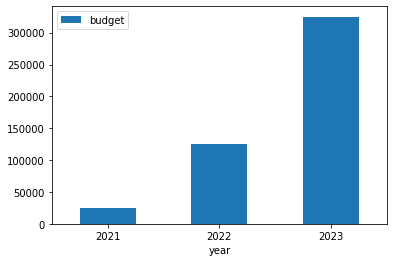

In [54]:
# Allocate project budget
budget = [{"year": 2021, "budget": 25000}, {"year": 2022, "budget": 125000}, {"year": 2023, "budget": 325000}]

route = project_budget_view.ProjectBudgetAPI.name
response = post_request(data=budget, route=route, auth_token=token_pm, path_param=[project_charter], type_json=True).json()

budget_list = response
years = []
budgets = []
for elem in response:
    years.append(elem.get('year')) 
    budgets.append(elem.get('budget'))

df = pd.DataFrame({'year': years, 'budget': budgets})
ax = df.plot.bar(x='year', y='budget', rot=0)

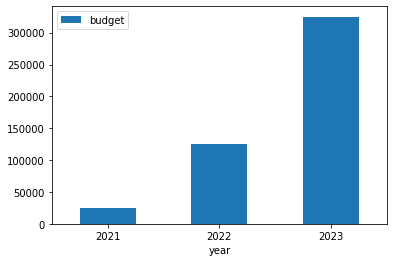

In [55]:
# Allocated budget
route = project_view.ProjectDetailsAPI.name
response = get_request(route=route, auth_token=token_pmo, path_param=[project]).json()
budget = response.get('project_charter').get('project_budget')

years = []
budgets = []
for elem in budget:
    years.append(elem.get('year')) 
    budgets.append(elem.get('budget'))

df = pd.DataFrame({'year': years, 'budget': budgets})
ax = df.plot.bar(x='year', y='budget', rot=0)

In [56]:
# as an author of the project
# assign project spending operations permissions to 'project manager'
content = {
    "user_id": pm,
    "project_id": project,
    "permissions": ["add_project_spendings", "delete_project_spendings", "change_project_spendings", "view_project_spendings"]  
}
route = project_budget_view.AddProjectBudgetPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 201:
    print("Result: Project spending operations permissions assigned")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Permission assignment failed")
    print("HTTP status code: ", response.status_code)

Result: Project spending operations permissions assigned
HTTP status code:  201


In [57]:
# As 'an author of the project'
# assign project spending operations permissions to 'project controller'
content = {
    "user_id": pc,
    "project_id": project,
    "permissions": ["add_project_spendings", "delete_project_spendings", "change_project_spendings", "view_project_spendings"]  
}
route = project_budget_view.AddProjectBudgetPermissionsOfUserAPI.name
response = post_request(data=content, route=route, auth_token=token_pmo, type_json=True)
if response.status_code == 201:
    print("Result: Project spending operations permissions assigned")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Permission assignment failed")
    print("HTTP status code: ", response.status_code)

Result: Project spending operations permissions assigned
HTTP status code:  201


In [58]:
# As 'project controller'
# add new resource spendings to the project
# Spendings status is 'denied' when total spending is over budget 
#
# resource spending 1
resource_id = resource_list[0].get('id')
budget_id = budget_list[0].get('id')
spending = {
    "project": project,
    "resource": resource_id,
    "budget": budget_id,
    "assignment": 15,
    "description": "salary payment",
    "date": "2021-08-12"
}
route = project_budget_view.AddResourceSpendingAPI.name
response = post_request(data=spending, route=route, auth_token=token_pc, type_json=True).json()
resource_spendings = [response.get('resource-spending')]

# resource spending 2
resource_id = resource_list[1].get('id')
budget_id = budget_list[0].get('id')
spending = {
    "project": project,
    "resource": resource_id,
    "budget": budget_id,
    "assignment": 24,
    "description": "salary payment",
    "date": "2021-07-13"
}
route = project_budget_view.AddResourceSpendingAPI.name
response = post_request(data=spending, route=route, auth_token=token_pc, type_json=True).json()
resource_spendings.append(response.get('resource-spending'))

# resource spending 3
resource_id = resource_list[1].get('id')
budget_id = budget_list[0].get('id')
spending = {
    "project": project,
    "resource": resource_id,
    "budget": budget_id,
    "assignment": 19,
    "description": "salary payment",
    "date": "2021-09-10"
}
route = project_budget_view.AddResourceSpendingAPI.name
response = post_request(data=spending, route=route, auth_token=token_pc, type_json=True).json()
resource_spendings.append(response.get('resource-spending'))
result = response.get('detail')

print("Result: ", result)
print("Resource spendings:")


df = pd.json_normalize(resource_spendings)
df

Result:  Project resource added successfully.
Resource spendings:


,id,project,resource,budget,assignment,amount,description,date,approval_status
0,63,52,72,130,15,180.0,salary payment,2021-08-12,approved
1,64,52,73,130,24,240.0,salary payment,2021-07-13,approved
2,65,52,73,130,19,190.0,salary payment,2021-09-10,approved


In [59]:
# As 'project controller'
# edit a resource spending
# may have partial attributes
spending_id = resource_spendings[2].get('id')
spending = {    
    "assignment": 3,
    "description": "payment of september",
    "date": "2021-09-12"
}
route = project_budget_view.UpdateResourceSpendingAPI.name
response = patch_request(data=spending, route=route, auth_token=token_pc, path_param=[spending_id], type_json=True)
if response.status_code == 200:
    print("Result: Project resource spending edited successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Update request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project resource spending edited successfully
HTTP status code:  200


In [60]:
# As 'project conroller'
# get details of a single resource spendings instance
spending_id = resource_spendings[2].get('id')
route = project_budget_view.GetResourceSpendingDetailsAPI.name
response = get_request(route=route, auth_token=token_pc, path_param=[spending_id]).json()

print('Project resource spending after editing:')
df = pd.json_normalize(response)
df

Project resource spending after editing:


,id,project,resource,budget,assignment,amount,description,date,approval_status
0,65,52,73,130,3,30.0,payment of september,2021-09-12,approved


In [61]:
# As 'project controller'
# delete a single resource spendings instance
spending_id = resource_spendings[2].get('id')
route = project_budget_view.DeleteResourceSpendingAPI.name
response = delete_request(route=route, auth_token=token_pc, path_param=[spending_id])
if response.status_code == 204:
    print("Result: Resource spending deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Resource spending deleted successfully
HTTP status code:  204


In [62]:
# As 'project controller'
# get project resource spendings by budget
budget_id = budget_list[0].get('id')
route = project_budget_view.GetResourceSpendingsByBudgetAPI.name
response = get_request(route=route, auth_token=token_pc, path_param=[budget_id]).json()

print('Project resource spendings by budget:')
df = pd.json_normalize(response)
df

Project resource spendings by budget:


,id,project,resource,budget,assignment,amount,description,date,approval_status
0,63,52,72,130,15,180.0,salary payment,2021-08-12,approved
1,64,52,73,130,24,240.0,salary payment,2021-07-13,approved


In [63]:
# As 'project controller'
# add new procurement spendings to the project
# Spendings status is 'denied' when total spending is over budget 
#
# add to a budget different from resource spending 
budget_id = budget_list[1].get('id')
# procurement spending 1
spending = {
    "project": project,
    "contract": contract_list[0].get('id'),
    "budget": budget_id,
    "description": "payment of procurement",
    "date": "2022-05-11"
}
route = project_budget_view.AddContractSpendingAPI.name
response = post_request(data=spending, route=route, auth_token=token_pc, type_json=True).json()
contract_spendings = [response.get('contract-spending')]

# procurement spending 2
spending = {
    "project": project,
    "contract": contract_list[0].get('id'),
    "budget": budget_id,
    "description": "payment of procurement",
    "date": "2022-03-14"
}
route = project_budget_view.AddContractSpendingAPI.name
response = post_request(data=spending, route=route, auth_token=token_pc, type_json=True).json()
contract_spendings.append(response.get('contract-spending'))

# procurement spending 3
spending = {
    "project": project,
    "contract": contract_list[0].get('id'),
    "budget": budget_id,
    "description": "payment of procurement",
    "date": "2022-07-13"
}
route = project_budget_view.AddContractSpendingAPI.name
response = post_request(data=spending, route=route, auth_token=token_pc, type_json=True).json()
contract_spendings.append(response.get('contract-spending'))
result = response.get('detail')

print("Result: ", result)
print("Contract spendings:")


df = pd.json_normalize(contract_spendings)
df

Result:  Procurement contract added successfully.
Contract spendings:


,id,project,contract,budget,amount,description,date,approval_status
0,38,52,49,131,250.0,payment of procurement,2022-05-11,approved
1,39,52,49,131,250.0,payment of procurement,2022-03-14,approved
2,40,52,49,131,250.0,payment of procurement,2022-07-13,approved


In [64]:
# As 'project controller'
# edit a procurement spending
# may have partial attributes
spending_id = contract_spendings[2].get('id')
spending = {    
    "description": "some information here",
    "date": "2022-08-12"
}
route = project_budget_view.UpdateContractSpendingAPI.name
response = patch_request(data=spending, route=route, auth_token=token_pc, path_param=[spending_id], type_json=True)
if response.status_code == 200:
    print("Result: Project procurement spending edited successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Update request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project procurement spending edited successfully
HTTP status code:  200


In [65]:
# As 'project controller'
# get details of a single procurement spendings instance
spending_id = contract_spendings[2].get('id')
route = project_budget_view.GetContractSpendingDetailsAPI.name
response = get_request(route=route, auth_token=token_pc, path_param=[spending_id]).json()

print('Project procurement spending after editing:')
df = pd.json_normalize(response)
df

Project procurement spending after editing:


,id,project,contract,budget,amount,description,date,approval_status
0,40,52,49,131,250.0,some information here,2022-08-12,approved


In [66]:
# As 'project controller'
# delete a single procurement spendings instance
spending_id = contract_spendings[2].get('id')
route = project_budget_view.DeleteContractSpendingAPI.name
response = delete_request(route=route, auth_token=token_pc, path_param=[spending_id])
if response.status_code == 204:
    print("Result: Procurement spending deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Procurement spending deleted successfully
HTTP status code:  204


In [67]:
# As 'project controller'
# get project procurement spendings by budget
budget_id = budget_list[1].get('id')
route = project_budget_view.GetContractSpendingsByBudgetAPI.name
response = get_request(route=route, auth_token=token_pc, path_param=[budget_id]).json()

print('Project procurement spendings by budget:')
df = pd.json_normalize(response)
df

Project procurement spendings by budget:


,id,project,contract,budget,amount,description,date,approval_status
0,38,52,49,131,250.0,payment of procurement,2022-05-11,approved
1,39,52,49,131,250.0,payment of procurement,2022-03-14,approved


In [68]:
# As 'project management office'
# get actual cost of a budget
# all current spendings of a budget year
budget_id = budget_list[0].get('id')
route = project_budget_view.GetActualCostOfProjectByBudgetAPI.name
response = get_request(route=route, auth_token=token_pmo, path_param=[budget_id]).json()

print('Current spendings of a budget year:')
df = pd.json_normalize(response)
df

Current spendings of a budget year:


,year,budget,actual_cost,resource_spendings,contract_spendings
0,2021,25000.0,420.0,420.0,0.0


In [69]:
# As 'project management office'
# get actual cost of entire project
# all current spendings of whole project
route = project_view.GetActualCostOfProjectAPI.name
response = get_request(route=route, auth_token=token_pmo, path_param=[project]).json()

print('Current spendings of whole project:')
df = pd.json_normalize(response)
df

Current spendings of whole project:


,actual_cost,resource_spendings,contract_spendings
0,920.0,420.0,500.0


In [70]:
# As 'project manager'
# get forecast balance of a project budget
budget_id = budget_list[0].get('id')
data = {
    "total_scheduled_tasks": 64,
    "task_duration": 8,
    "employee_cost_day": 800,
    "actual_activity": [4, 5, 3, 4, 5, 7, 6, 3]
}
route = project_budget_view.ForecastBalanceAPI.name
response = post_request(data=data, route=route, auth_token=token_pm, path_param=[budget_id], type_json=True).json()

print("Forecast Balance for", data.get("task_duration"), "days:")
df = pd.DataFrame.from_dict(response.items())
df.columns = ['Parameters', 'Values']
pd.options.display.max_colwidth = 130
df

Forecast Balance for 8 days:


,Parameters,Values
0,estimate_to_complete,"[800.0, 1244.4444444444443, 2400.0, 3200.0, 3619.047619047619, 3428.5714285714284, 3623.5294117647063, 4670.27027027027]"
1,estimate_at_complete,"[1600.0, 2844.4444444444443, 4800.0, 6400.0, 7619.047619047618, 8228.571428571428, 9223.529411764706, 11070.27027027027]"


In [71]:
# As 'project manager'
# forecast future spendings of a project due to budget
budget_id = budget_list[0].get('id')
data = {
    "total_scheduled_tasks": 64,
    "task_duration": 8,
    "employee_cost_day": 800,
    "actual_activity": [4, 5, 3, 4, 5, 7, 6, 3]
}
route = project_budget_view.ForecastFutureSpendingsAPI.name
response = post_request(data=data, route=route, auth_token=token_pm, path_param=[budget_id], type_json=True).json()

print("Forecasting Results for", data.get("task_duration"), "days:")
df = pd.DataFrame.from_dict(response.items())
df.columns = ['Parameters', 'Values']
pd.options.display.max_colwidth = 130
df

Forecasting Results for 8 days:


,Parameters,Values
0,planned_work_percentage,"[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]"
1,budget_work,"[8, 16, 24, 32, 40, 48, 56, 64]"
2,actual_work_percentage,"[0.0625, 0.140625, 0.1875, 0.25, 0.328125, 0.4375, 0.53125, 0.578125]"
3,budgeted_cost_of_work_scheduled,"[800.0, 1600.0, 2400.0, 3200.0, 4000.0, 4800.0, 5600.0, 6400.0]"
4,actual_cost_of_work_performed,"[800.0, 1600.0, 2400.0, 3200.0, 4000.0, 4800.0, 5600.0, 6400.0]"
5,budgeted_cost_of_work_performed,"[400.0, 900.0, 1200.0, 1600.0, 2100.0, 2800.0, 3400.0, 3700.0]"
6,earned_value,"[400.0, 900.0, 1200.0, 1600.0, 2100.0, 2800.0, 3400.0, 3700.0]"
7,schedule_performance_index,"[0.5, 0.5625, 0.5, 0.5, 0.525, 0.5833333333333334, 0.6071428571428571, 0.578125]"
8,schedule_variance,"[-400.0, -700.0, -1200.0, -1600.0, -1900.0, -2000.0, -2200.0, -2700.0]"
9,schedule_variance_percentage,"[-0.5, -0.4375, -0.5, -0.5, -0.475, -0.4166666666666667, -0.39285714285714285, -0.421875]"


In [72]:
# As 'project management office'
# get entire project
route = project_view.ProjectDetailsAPI.name
response = get_request(route=route, auth_token=token_pmo, path_param=[project_id]).json()
author = response.get('author')
stakeholders = response.get('stakeholders')
project_charter = response.get('project_charter')
bus_case_swot = project_charter.get('bus_case_swot')
project_budget = project_charter.get('project_budget')
project_charter.pop('bus_case_swot')
project_charter.pop('project_budget')
response.pop('author')
response.pop('stakeholders')
response.pop('project_charter')
response["created"] = datetime.strptime(response.get("created"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)
project_charter["created"] = datetime.strptime(project_charter.get("created"), '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)
project_charter["last_updated"] = datetime.strptime(project_charter.get("last_updated"), 
                                                    '%Y-%m-%dT%H:%M:%S.%fZ').replace(microsecond=0)

print("Project:")
display(pd.json_normalize(response))
print("Author of project:")
display(pd.json_normalize(author))
print("Stakeholders of project:")
display(pd.json_normalize(stakeholders))
print("Project charter:")
display(pd.json_normalize(project_charter))
print("Business case SWOT:")
display(pd.json_normalize(bus_case_swot))
print("Project budget:")
display(pd.json_normalize(project_budget))

Project:


,id,project_name,created
0,52,Thesis project,2022-06-05 14:49:19


Author of project:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO


Stakeholders of project:


,id,first_name,last_name,email,user_role
0,36,Luca,Verdi,pmo@email.com,PMO
1,37,Lucas,Andos,pm@email.com,PM
2,39,Maria,Lilla,pc@email.com,PC


Project charter:


,id,project,author,created,last_updated,sow,contract,business_case
0,33,52,37,2022-06-05 14:50:13,2022-06-05 14:50:15,standard thesis outline,Guida Studente DIGEP per la tesi,Research Case Digital PM


Business case SWOT:


,id,project_charter,swot_type,content
0,107,33,opportunity,Very small legacy in PIMS
1,108,33,opportunity,A standard for PM exists
2,109,33,weakness,Front ends must be custom built according to corporate paractices and back end constraints


Project budget:


,id,project_charter,year,budget
0,130,33,2021,25000.0
1,131,33,2022,125000.0
2,132,33,2023,325000.0


In [73]:
# As 'project manager'
# delete a project charter
route = project_charter_view.DeleteProjectCharterAPI.name
response = delete_request(route=route, auth_token=token_pm, path_param=[project_charter_id])
if response.status_code == 204:
    print("Result: Project charter deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project charter deleted successfully
HTTP status code:  204


In [74]:
# As 'project management office' and 'author of a project'
# delete an entire project
route = project_view.DeleteProjectAPI.name
response = delete_request(route=route, auth_token=token_pmo, path_param=[project])
if response.status_code == 204:
    print("Result: Project deleted successfully")
    print("HTTP status code: ", response.status_code)
else: 
    print("Result: Delete request failed")
    print("HTTP status code: ", response.status_code)
    if "detail" in response.json():
        print('detail: ', response.json().get('detail'))

Result: Project deleted successfully
HTTP status code:  204
